# Correlation

Find Pearson (maybe Spearman?) correlation between covid and library variables

Note:
First tried Cases vs Circulation

* Cases vs Circulation
* Cases vs Visitors
* Deaths vs Circulation
* Deaths vs Visitors

In [1]:
# Import modules
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.lines import Line2D
import matplotlib
import scipy.stats as st
import numpy as np
import os

# Load data
library_path = "../Data/merged_library_covid_outer.csv"
df = pd.read_csv(library_path)
df = df.drop(['Unnamed: 0'], axis = 1)
df.head()

,ADDRESS,CITY,ZIP,JANUARY,FEBRUARY,MARCH,APRIL,MAY,JUNE,JULY,AUGUST,SEPTEMBER,OCTOBER,NOVEMBER,DECEMBER,YTD,TYPE,YEAR,LAT,LNG
0,3401 W. Foster Ave.,Chicago,60625,8214.0,7614.0,8460.0,7414.0,7044.0,7970.0,9664.0,9069.0,7053.0,8012.0,6571.0,5924.0,93009.0,Circulation,2019,41.971155,-87.701816
1,13281 S. Corliss Ave.,Chicago,60827,378.0,326.0,332.0,270.0,320.0,325.0,354.0,229.0,234.0,377.0,369.0,500.0,4014.0,Circulation,2019,41.650765,-87.633087
2,5055 S. Archer Ave.,Chicago,60632,5365.0,5019.0,5417.0,5349.0,4833.0,4627.0,5356.0,4793.0,4537.0,5263.0,4051.0,3415.0,58025.0,Circulation,2019,41.810038,-87.711251
3,5615 W. Race Ave.,Chicago,60644,215.0,590.0,706.0,736.0,806.0,983.0,1134.0,1236.0,1193.0,1361.0,1286.0,1082.0,11328.0,Circulation,2019,41.881113,-87.756863
4,6100 W. Irving Park Rd.,Chicago,60634,9678.0,9764.0,10845.0,10541.0,9763.0,11442.0,11634.0,11063.0,9379.0,9932.0,8567.0,6492.0,119100.0,Circulation,2019,41.944967,-87.797373


# Deaths and Visitors

### Isolate covid deaths data and visitors data with corresponding years and zip codes

In [2]:
# Isolate circulation and cases data
visitors = df[df['TYPE'] == 'Visitors']
deaths = df[df['TYPE'] == 'Deaths']

# Subset for shared ZIPs
shared_zips =  list(set(visitors['ZIP']) & set(deaths['ZIP']))
shared_zips.remove(60611)
visitors = visitors[visitors['ZIP'].isin(shared_zips)]
deaths = deaths[deaths['ZIP'].isin(shared_zips)]

# Subset for shared years
shared_years =  list(set(visitors['YEAR']) & set(deaths['YEAR']))
visitors = visitors[visitors['YEAR'].isin(shared_years)]
deaths = deaths[deaths['YEAR'].isin(shared_years)]

# Sort by year
deaths = deaths.sort_values(by = ['YEAR', 'ZIP'], axis = 0)
visitors = visitors.sort_values(by = ['YEAR', 'ZIP'], axis = 0)

# Isolate monthly data of interest
monthly_deaths = deaths.loc[:,"JANUARY":"DECEMBER"]

# Average circulation data for each year and zip code combination
visitors_grouped = visitors.groupby(['YEAR', 'ZIP'])
monthly_visitors = visitors_grouped[['JANUARY', 'FEBRUARY', 'MARCH', 'APRIL', 'MAY', 'JUNE', 'JULY',
                                       'AUGUST', 'SEPTEMBER', 'OCTOBER', 'NOVEMBER', 'DECEMBER']].mean()
monthly_visitors = pd.DataFrame(monthly_visitors)

# Heatmap of correlation b/w deaths/age and visitors/age for each zip
Question: Which zip codes had the most similar deaths over time progressionss and visitors over time progressions? Do any zip codes show more correlation between deaths and visitors than others?

### Prepare data

In [3]:
# Initialize lists
deaths_lists = []
visitors_lists = []

for zipcode in shared_zips:
    # Subset zip code of interest
    visitors_zip = visitors[visitors['ZIP'] == zipcode]
    deaths_zip = deaths[deaths['ZIP'] == zipcode]
    
    # Extract monthly data
    deaths_monthly = deaths_zip.loc[:,"JANUARY":"DECEMBER"]
    visitors_zip_grouped = visitors_zip.groupby(['YEAR', 'ZIP'])
    visitors_monthly = pd.DataFrame(visitors_zip_grouped[['JANUARY', 'FEBRUARY', 'MARCH', 'APRIL', 'MAY', 'JUNE', 'JULY',
                                             'AUGUST', 'SEPTEMBER', 'OCTOBER', 'NOVEMBER', 'DECEMBER']].mean())
    
    # Make list of monthly data
    # Remove first two elements (no january or february 2020 deaths recorded)
    deaths_list = (deaths_monthly.iloc[0,:].tolist() + deaths_monthly.iloc[1,:].tolist())[2:24]
    visitors_list = (visitors_monthly.iloc[0,:].tolist() + visitors_monthly.iloc[1,:].tolist())[2:24]
    
    # Append lists
    deaths_lists.append(deaths_list)
    visitors_lists.append(visitors_list)

# Aggregate lists
deaths_zip = pd.DataFrame(deaths_lists).transpose()
visitors_zip = pd.DataFrame(visitors_lists).transpose()

# Add column names
deaths_zip.columns = shared_zips
visitors_zip.columns = shared_zips

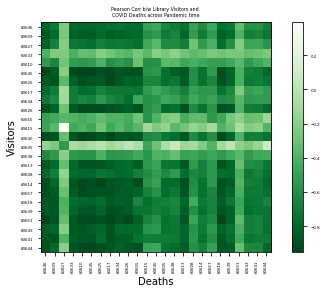

In [4]:
# Merge together
zip_df = pd.concat([deaths_zip, visitors_zip], axis = 1)

# Generate correlation matrix
corr = zip_df.corr(method = 'pearson')

# Find ZIPs with greatest deaths to visits correlation
corr = corr.abs()
corr[ corr == 1] = 0
corr.iloc[0:48, 0:48] = 0
corr.iloc[48:96, 48:96] = 0
max_zips = corr.idxmax().unique()
deaths_visitors_max_zips = max_zips
    
# Regenerate corr matrix with only zips of interest
zip_df.columns = [str(zipcode) + " deaths" for zipcode in shared_zips] + [str(zipcode) + " visitors" for zipcode in shared_zips]
max_zips_annotated = [str(zipcode) + " deaths" for zipcode in max_zips] + [str(zipcode) + " visitors" for zipcode in max_zips]
corr = zip_df[max_zips_annotated].corr(method = 'pearson')
deaths_visitors_corr = corr.iloc[0:len(max_zips),len(max_zips):(len(max_zips)*2)]

# Generate heatmap
fig, ax = plt.subplots()
plt.rcParams.update({'figure.figsize':(4,4), 'figure.dpi':300, 'font.size':4})
im = ax.imshow(deaths_visitors_corr, cmap = 'Greens_r')
cb = fig.colorbar(im)
ax.set_title('Pearson Corr b/w Library Visitors and \nCOVID Deaths across Pandemic time')
ax.set_xlabel('Deaths')
ax.set_ylabel('Visitors')
ax.set_xticks(range(len(max_zips)))
ax.set_xticklabels(max_zips, rotation = 90, size = 4)
ax.set_yticks(range(len(max_zips)))
ax.set_yticklabels(max_zips, size = 4)
fig.tight_layout()

# Export plot
plt.savefig('../Figures/visitors_vs_deaths_spearman_heatmap.png')

plt.show()

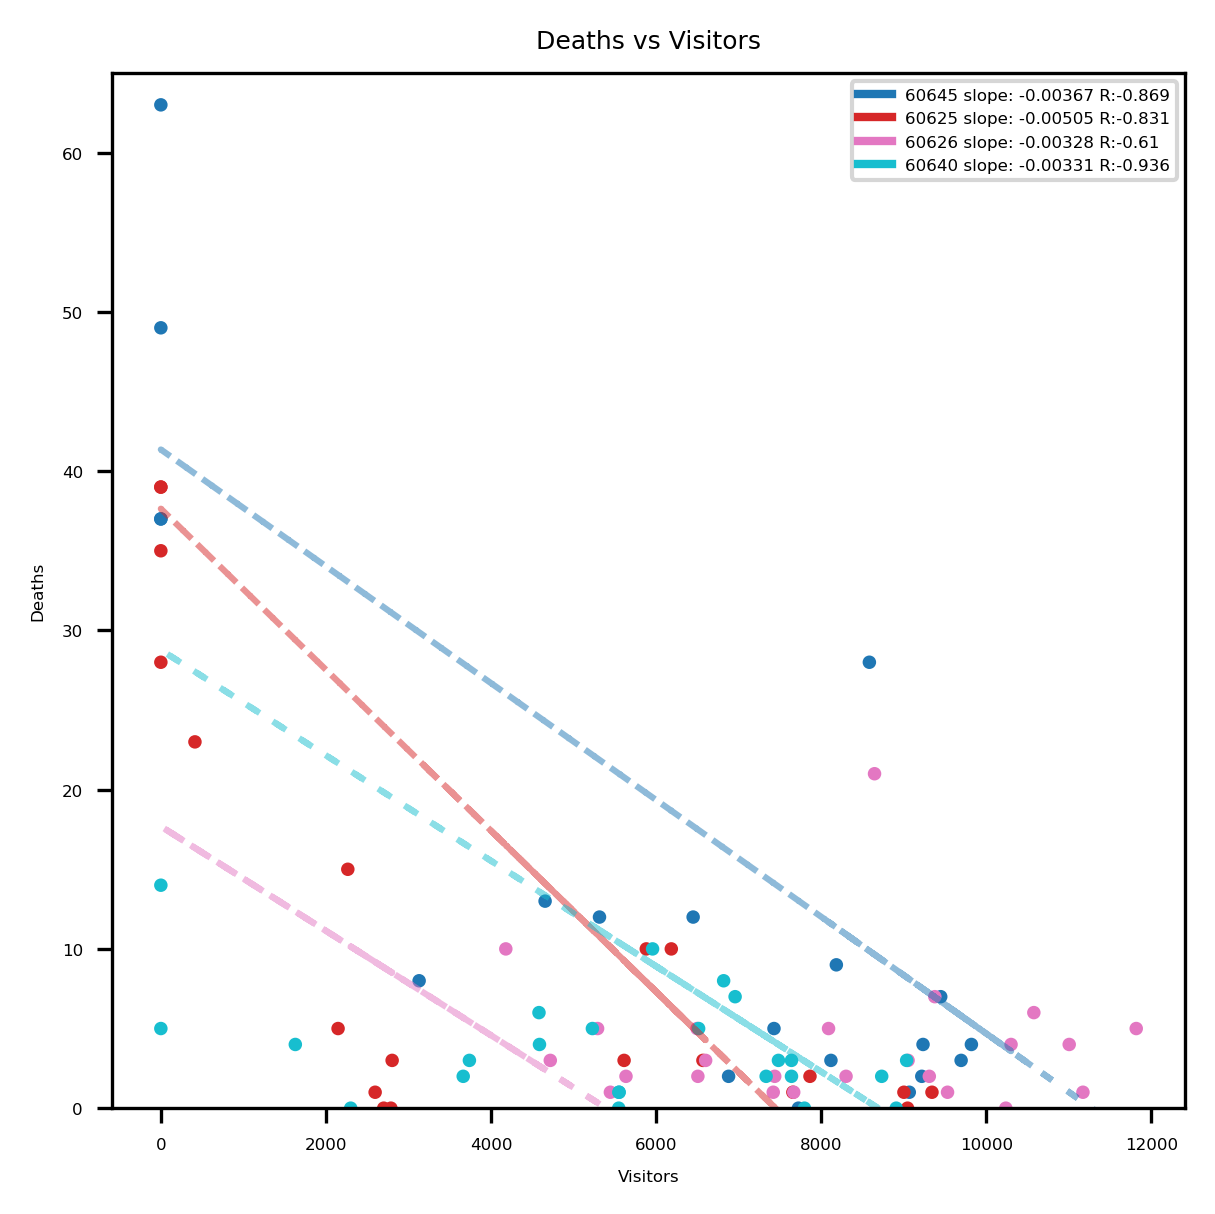

In [5]:
# Plot scatter for zips of interest (60645, 60625, 60626, 60640)
# Subset data
zips_oi = [60645, 60625, 60626, 60640]

monthly_visitors_reset = monthly_visitors.reset_index()
monthly_visitors_sub = monthly_visitors_reset[ (monthly_visitors_reset["ZIP"]).isin(zips_oi) ]
monthly_visitors_sub = monthly_visitors_sub.loc[:,"JANUARY":"DECEMBER"]
deaths_sub = deaths[ (deaths["ZIP"]).isin(zips_oi) ]
monthly_deaths_sub = deaths_sub.loc[:,"JANUARY":"DECEMBER"]

# Define color vector for each ZIP code
colors = cm.tab10(np.linspace(0, 1, len(zips_oi)))
colors_hex = [matplotlib.colors.rgb2hex(color) for color in colors]
colors_rep = np.repeat(colors_hex, 24)

# Generate lines for legend
custom_lines = [Line2D([0], [0], color=colors_hex[0], lw=2),
                Line2D([0], [0], color=colors_hex[1], lw=2),
                Line2D([0], [0], color=colors_hex[2], lw=2),
                Line2D([0], [0], color=colors_hex[3], lw=2)]

# Generate plot
fig, ax = plt.subplots()
plt.rcParams.update({'figure.figsize':(2,2), 'figure.dpi':300, 'font.size':5})
plt.scatter(monthly_visitors_sub, monthly_deaths_sub, s = 5, c = colors_rep)

legend_labels = []
# Add regression
for i in np.arange(4): 
    x_values = np.array(monthly_visitors_sub.iloc[i,2:].tolist() + monthly_visitors_sub.iloc[i+4,:].tolist())
    y_values = monthly_deaths_sub.iloc[i,2:].tolist() + monthly_deaths_sub.iloc[i+4,:].tolist()
    (slope, intercept, rvalue, pvalue, stderr) = st.linregress(x_values, y_values)
    plt.plot(x_values, slope*x_values + intercept, '--', color = colors_hex[i], alpha = 0.5, dashes=(2, 3))
    r = round(st.pearsonr(y_values, x_values)[0], 3)
    legend_labels.append(str(zips_oi[i]) + " slope: " + str(round(slope, 5)) + " R:" + str(r))
    
ax.set_title('Deaths vs Visitors')
ax.set_xlabel('Visitors')
ax.set_ylabel('Deaths')
ax.set_ylim(0,65)
ax.legend(custom_lines, legend_labels, prop={'size': 4})
fig.tight_layout()

# Export plot
plt.savefig('../Figures/deaths_vs_visitors_scatter_zips_oi.png')

plt.show()